In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

DOWNLOAD DATSET FROM KAGGLE

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p "/content/drive/MyDrive/my projects/Brain Tumor Classification Using Convolutional Neural Networks (CNNs)"

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


EXTRACTING THE ZIP FILE TO A FOLDER data_dir

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/my projects/Brain Tumor Classification Using Convolutional Neural Networks (CNNs)/brain-tumor-mri-dataset.zip', 'r') as zip_ref:
     zip_ref.extractall('/content/drive/MyDrive/my projects/Brain Tumor Classification Using Convolutional Neural Networks (CNNs)/Data/')
gpus =tf.config.experimental.list_physical_devices('CPU')
#Avoid OOM errors by setting gpu consumption growth
gpus =tf.config.experimental.list_physical_devices('GPU')

# Avoid OOM errors by setting GPU memory growth
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
# Set paths for datasets
train_data_dir = '/content/drive/MyDrive/my projects/Brain Tumor Classification Using Convolutional Neural Networks (CNNs)/Data/Training'
test_data_dir = '/content/drive/MyDrive/my projects/Brain Tumor Classification Using Convolutional Neural Networks (CNNs)/Data/Testing'
# Define image size
img_height, img_width = 224, 224

LOAD AND PREPROCESS IMAGES

In [ ]:
# Load and preprocess images
def load_images_and_labels(data_dir):
  # Dictionary to map folder names to label indices
  labels_dict = {'glioma': 0, 'meningioma': 1, 'notumor': 2,'pituitary': 3}

  # Initialize empty lists to store image data and labels
  data = []
  labels = []
  # Iterate through each folder in the data directory
  for folder in os.listdir(data_dir):
    # Construct the full path to the folder
    folder_path = os.path.join(data_dir, folder)

    # Check if the folder is a directory (not a file)
    if not os.path.isdir(folder_path):
      continue

    # Iterate through each image file in the folder
    for img_name in os.listdir(folder_path):
      # Construct the full path to the image file
      img_path = os.path.join(folder_path, img_name)

      try:
        # Load the image using Keras' load_img function
        img = load_img(img_path, target_size=(img_height,img_width))
        # Convert the image to a numpy array using Keras' img_to_array function
        img = img_to_array(img)

        # Append the image data to the data list
        data.append(img)

        # Append the corresponding label to the labels list
        labels.append(labels_dict[folder])

      except Exception as e:
       # Print an error message if there's an issue loading the image
       print(f"Error loading image {img_path}: {e}")
       # Convert the data and labels lists to numpy arrays
  return np.array(data), np.array(labels)
# Load train data and labels
train_data, train_labels = load_images_and_labels(train_data_dir)

In [ ]:
# Load test data and labels
test_data, test_labels = load_images_and_labels(test_data_dir)

DATA PREPROCESSING **************************************
NORMALISE DATA **********************************

In [ ]:
# Normalize the data
train_data = train_data / 255.0 # Normalize train data to range [0, 1]
test_data = test_data / 255.0 # Normalize test data to range [0, 1]

DISPLAY IMAGES **************************************************

DISPLAY TRAIN IMAGES ************************************

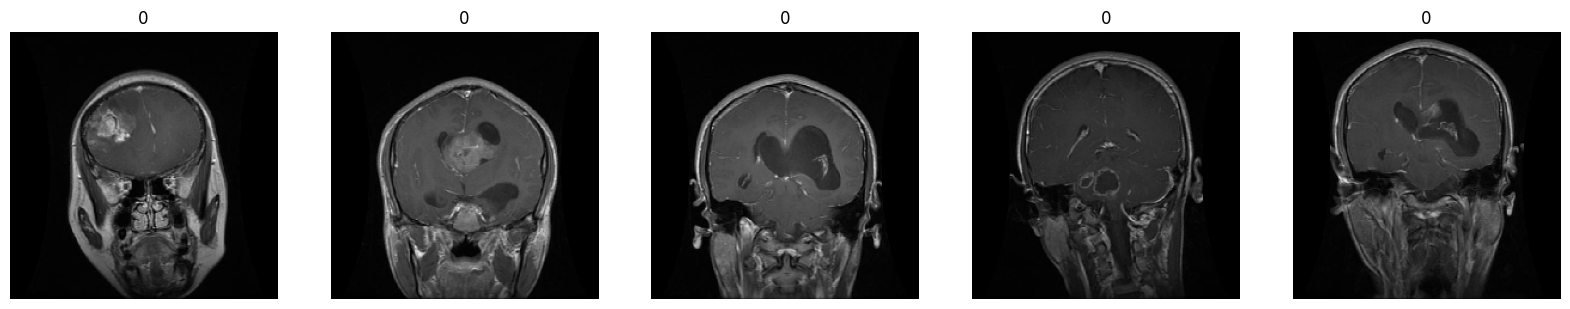

In [ ]:
# Display 5 random images from the training set in a horizontal line
fig, axs = plt.subplots(1, 5, figsize=(20, 5)) # Create a figure with 1 row and 5 columns
for i in range(5):
 axs[i].imshow(train_data[i]) # Display the image in the current subplot
 axs[i].set_title(train_labels[i]) # Set the title of the subplot to the corresponding label
 axs[i].axis('off') # Turn off the axis for the subplot
plt.show() # Display the figure

DISPLAY TEST IMAGES *************************************


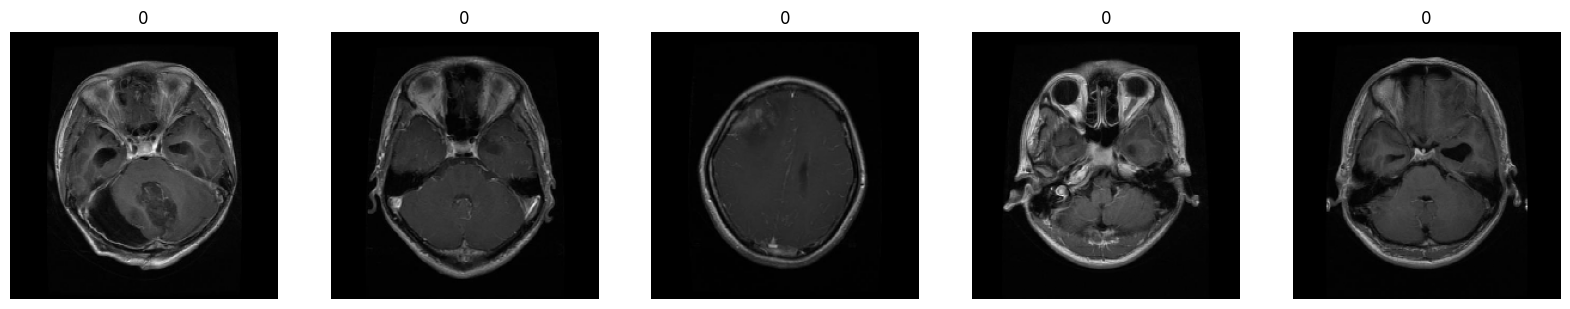

In [ ]:
# Display 5 random images from the testing set in a horizontal line
fig, axs = plt.subplots(1, 5, figsize=(20, 5)) # Create a figure with 1 row and 5 columns
for i in range(5):
 axs[i].imshow(test_data[i]) # Display the image in the current subplot
 axs[i].set_title(test_labels[i]) # Set the title of the subplot to the corresponding label
 axs[i].axis('off') # Turn off the axis for the subplot
plt.show() # Display the figur

SPLIT THE DATA *******************************

In [ ]:
# Split the train data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_data,train_labels, test_size=0.2, random_state=42, stratify=train_labels)
# Split train data into training and validation sets
# Split the test data into test set
x_test = test_data # Test data remains unchanged
y_test = test_labels # Test labels remain unchanged

LABEL CONVERSION **************************


In [ ]:
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4) # Convert train labels to categorical
y_val = tf.keras.utils.to_categorical(y_val, num_classes=4) # Convert validation labels to categorical
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4) # Convert test labels to categorical


MODEL DEFINITION *********************


In [ ]:
# Define the model
model = Sequential([ # Define a sequential model
 Conv2D(32, (3, 3), activation='relu', input_shape=(img_height,img_width, 3)), # Convolutional layer with 32 filters
 MaxPooling2D(pool_size=(2, 2)), # Max pooling layer
 Conv2D(64, (3, 3), activation='relu'), # Convolutional layer with 64 filters
 MaxPooling2D(pool_size=(2, 2)), # Max pooling layer
 Conv2D(128, (3, 3), activation='relu'), # Convolutional layer with 128 filters
 MaxPooling2D(pool_size=(2, 2)), # Max pooling layer
 Flatten(), # Flatten layer
 Dense(256, activation='relu'), # Dense layer with 256 units
 Dropout(0.5), # Dropout layer with 50% dropout rate
 Dense(4, activation='softmax') # Output layer with 4 units and softmax activation
])

MODEL COMPILATION ***********************

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy',
metrics=['accuracy']) # Compile the model with Adam optimizer and categorical crossentropy loss


MODEL TRAINING ************************************


In [ ]:
# Train the model
hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val)) # Train the model on training data with validation onvalidation data


PLOT PERFORMANCE OF TRAIN DATA
************************************************************************************

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Validation loss of Train data')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Inference from Validation Loss Plot
1. Trend Observation: o Training Loss: The training loss decreases steadily over the epochs,
indicating that the model is learning from the training data. o Validation Loss: The
validation loss decreases initially and then stabilizes, with slight fluctuations towards the
end.
2. Model Performance: o The decreasing trend in training loss shows that the model is
effectively learning the training data. o The validation loss stabilizes after a few epochs,
indicating that the model's performance on the validation data is consistent.
3. Overfitting Check: o There is no significant divergence between the training and
validation loss, which suggests that the model is not overfitting. Overfitting would be
indicated by a much lower training loss compared to the validation loss.
4. Convergence: o Both training and validation losses appear to converge, which indicates
that the model has reached a good fit on the data. Result Obtained from validation Loss
Plot The plot demonstrates that the model has successfully learned the training data and
generalizes well to the validation data without overfitting. The slight fluctuations in
validation loss are normal and indicate the inherent variability in the validation dataset.

In [ ]:
#visualise accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy of Train')
fig.suptitle('Accuracy', fontsize=20)
Text(0.5, 0.98, 'Accuracy')


NameError: name 'plt' is not defined

Inference from Validation Accuracy Plot Trend Observation:
*****************************************
Training Accuracy: The training accuracy increases steadily over the epochs, indicating that the model is effectively learning from the training data.
Validation Accuracy: The validation accuracy also increases initially and then stabilizes, with minor fluctuations.
Model Performance: ****************************************
The increasing trend in training accuracy shows that the model is learning the training data well. The validation accuracy stabilizes and remains consistently high, indicating that the model performs well on unseen data.
Overfitting Check: ******************************************
The training accuracy is slightly higher than the validation accuracy, but there is no significant gap between the two. This suggests that the model is not overfitting significantly. Overfitting would be indicated by a much higher training accuracy compared to validation accuracy, which is not evident here.
Convergence: ******************************************
Both training and validation accuracy curves converge, which indicates that the model has achieved a good fit on the data.
Conclusion ******************************************
The plot demonstrates that the model has successfully learned the training data and generalizes well to the validation data without
significant overfitting. The model achieves a high accuracy on both training and validation datasets, which indicates effective performance.

MODEL EVALUATION **************************************************************


In [ ]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(x_val, y_val) # Evaluate the model on validation data
print(f'Validation accuracy: {val_acc:.2f}') # Print validation accuracy
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test) # Evaluate the model on test data
print(f'Test accuracy: {test_acc:.2f}') # Print test accuracy

The model's accuracy on the validation dataset is 94%. This means that 94% of the predictions made by the model on the validation data are correct. The validation loss value is 0.3050. Loss represents the error the model makes; a lower loss indicates better performance.
• The model's accuracy on the test dataset is 95%. This means that 95% of the predictions made by the model on the test data are correct.
• The test loss value is 0.2864. Similar to validation loss, this is a measure of the model’s error on the test data. Overall Interpretation
• High Accuracy: The high accuracy values on both the validation (94%) and test datasets (95%) indicate that the model performs well not only on the data it was trained on but also on unseen data.
• Generalization: The close accuracy values between the validation and test datasets suggest that the model
generalizes well, meaning it performs consistently across different datasets.
• Low Loss Values:The relatively low loss values further confirm the model's good performance.


MODEL PREDICTION *********************************


In [ ]:
# Make predictions
y_pred = model.predict(x_test) # Make predictions on test data
# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1) # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1) # Get true class labels

MODEL METRICS *********************************************

In [ ]:
# Print classification report
print(classification_report(y_true, y_pred_class)) # Print classification report
# Print confusion matrix
print(confusion_matrix(y_true, y_pred_class)) # Print confusion matrix

• Class 0:Strong performance with high precision and recall, indicating accurate classification
with minimal false positives and negatives.
• Class 1:Good performance with a lower recall
compared to Class 0, suggesting some misclassification. Solid F1-Score of 0.89. • Class 2:Perfect
recall, indicating all instances of Class 2 are correctly identified. High precision and F1-Score.
•Class 3:Exceptional performance with the highest precision, recall, and F1-Score.
• True Positives: Diagonal values (279, 266, 404, 298) represent correct classifications for each
class.
• False Negatives: Off-diagonal values in each row (e.g., 21 for Class 0) indicate
misclassified instances.
• False Positives: Off-diagonal values in each column (e.g., 10 for Class 1)
show instances incorrectly classified as that class. Observation: The majority of predictions are correctly classified, with only minor misclassifications observed. The model performs effectively with high accuracy, though further refinements could be explored to address the few misclassifications.

CONFUSION MATRIX PLOT
*******************************************************************

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Print confusion matrix
cm = confusion_matrix(y_true, y_pred_class)
# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


ROC-AUC SCORE **************************


In [ ]:
# Calculate ROC-AUC score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC Score: {roc_auc:.2f}')

SAVE THE MODEL ***********************

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/my projects/Brain Tumor Classification Using Convolutional Neural Networks (CNNs)/CNN_image_classification_model.h5')

DOING TEST ON AN UNSEEN IMAGE *********************************


In [ ]:
# Load unseen image
from PIL import Image
import numpy as np
img_path = 'testunseen.jpg'
img = Image.open(img_path)
img = img.resize((img_height, img_width))
img_array = np.array(img)
img_array = img_array / 255.0
# Display unseen image
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title('Unseen Image')
plt.show()

PREDICT CLASS CORRECTLY ************************


In [ ]:
# Load unseen images
unseen_img_paths = ['testunseen1.jpg', 'testunseen2.jpg' ]
for img_path in unseen_img_paths:
    img = Image.open(img_path)
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    # Display unseen image
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title('Unseen Image')
    plt.show()
    # Import necessary libraries
    from tensorflow.keras.models import load_model
    # Load the model
    model = load_model('CNN_image_classification_model.h5')
    # Reshape array
    img_array = np.expand_dims(img_array, axis=0)
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    # Get class name
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    predicted_class_name = class_names[predicted_class]
    # Print predicted class
    print(f'Predicted Class for {img_path}: {predicted_class_name}')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Load new image
new_img = Image.open('testunseen.jpg')
# Display loaded image
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
plt.title('Loaded Image')
plt.show()
# Resize new image
new_img = new_img.resize((224, 224)) # Assuming original image size
is (224, 224)
# Convert new image to RGB (if necessary)
new_img = new_img.convert('RGB')
# Preprocess new image (if necessary)
new_img_array = np.array(new_img) / 255.0 # Normalize pixel values
# Make prediction with new image
prediction = model.predict(new_img_array.reshape((1, 224, 224, 3)))
# Get the predicted class index
predicted_class_index = np.argmax(prediction)
# Map the predicted class index to the class name
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted Class: {predicted_class_name}')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Load new image
new_img = Image.open('testunseen0.jpg')
# Display loaded image
plt.figure(figsize=(6, 6))
plt.imshow(new_img)
plt.title('Loaded Image')
plt.show()
# Resize new image
new_img = new_img.resize((224, 224)) # Assuming original image size is (224, 224)
# Convert new image to RGB (if necessary)
new_img = new_img.convert('RGB')
# Preprocess new image (if necessary)
new_img_array = np.array(new_img) / 255.0 # Normalize pixel values
# Make prediction with new image
prediction = model.predict(new_img_array.reshape((1, 224, 224, 3)))
# Get the predicted class index
predicted_class_index = np.argmax(prediction)
# Map the predicted class index to the class name
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted Class: {predicted_class_name}')

In [ ]:
import streamlit as st
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
import os
# Load the trained model
try:
 model = load_model('CNN_image_classification_model.h5')
 st.success('Model loaded successfully.')
except Exception as e:
 st.error(f"Error loading model: {e}")
# Define a function to make predictions
def predict(image):
 try:
 image = image.resize((224, 224))
 image = np.array(image) / 255.0
 image = np.expand_dims(image, axis=0)
 prediction = model.predict(image)
 return prediction
 except Exception as e:
 st.error(f"Error making prediction: {e}")
# Create a Streamlit app
st.title('Brain Tumor Classification')
# Specify the paths to the images
image_paths = [
 'testunseen.jpg',
 'testunseen0.jpg',
 'testunseen1.jpg',
 'testunseen2.jpg'
]
# Process and make predictions on the specified images
for image_path in image_paths:
 if os.path.exists(image_path):
 try:
 # Open the image
 image = Image.open(image_path)

 # Display the image
 st.image(image, caption=f'Image: {image_path}',use_column_width=True)

 # Make prediction
 prediction = predict(image)
 st.write(f'Prediction for {image_path}:')
 st.write(prediction)
 # Display the predicted class with labels
 class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
 predicted_class = class_names[np.argmax(prediction)]
 st.write(f"Predicted Class: {predicted_class}")
 except Exception as e:
 st.error(f"Error processing image {image_path}: {e}")
 else:
 st.error(f"Image file {image_path} not found.")
